# Workshop 1: Mistral AI Models on AWS

Welcome to this hands-on workshop! By the end of this session, you'll have explored Mistral AI's powerful models and deployed them using Amazon Bedrock and SageMaker.

### What You'll Learn:
- Using Pixtral Large for multimodal vision and text capabilities
- Leveraging Mistral Small 3 for text analysis and generation
- Using Mistral OCR model for document extraction
- Deploying models on Amazon Bedrock and SageMaker


## Step 1: Environment Setup

In [1]:
from IPython.display import display, Image as IPImage
import boto3
import json
import sagemaker
import time
from botocore.exceptions import ClientError

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Part 1: Pixtral Large - Multimodal Vision Model on Amazon Bedrock

**Pixtral Large** is Mistral's state-of-the-art multimodal model combining:
- **124B parameters** (123B multimodal decoder + 1B vision encoder)
- **128K context window** supporting up to 30 high-resolution images
- **Advanced vision understanding** for documents, charts, and complex visuals

In [2]:
def get_mistral_response(prompt_text, image_path=None, show_image=True, temperature=0.3):
    """Get response from Pixtral Large model on Bedrock"""
    model_id = "us.mistral.pixtral-large-2502-v1:0" # EU region use: eu.mistral.pixtral-large-2502-v1:0
    bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2") #change region if needed

    image_paths = image_path if isinstance(image_path, list) else [image_path] if image_path else []

    if image_paths and show_image:
        for img_path in image_paths:
            print("Input Image:\n")
            display(IPImage(filename=img_path))
            print("\n")

    # Initialize message content with prompt text
    message_content = [{"text": prompt_text}]

    # Add images to content if provided
    if image_paths:
        for img_path in image_paths:
            image_ext = img_path.split(".")[-1]
            if image_ext.lower() == 'jpg':
                image_ext = 'jpeg'

            with open(img_path, "rb") as f:
                image = f.read()
            
            message_content.append({
                "image": {
                    "format": image_ext,
                    "source": {"bytes": image}
                }
            })

    message = {
        "role": "user",
        "content": message_content
    }

    try:
        response = bedrock_client.converse(
            modelId=model_id,
            messages=[message],
            inferenceConfig={"temperature": temperature}
        )

        output_message = response['output']['message']
        content_blocks = output_message['content']
        result_text = "\n".join(f"{block['text']}" for block in content_blocks)
        return result_text

    except Exception as err:
        return f"A client error occurred: {err}"

### Use Case 1: Data Visualization Analysis

Input Image:



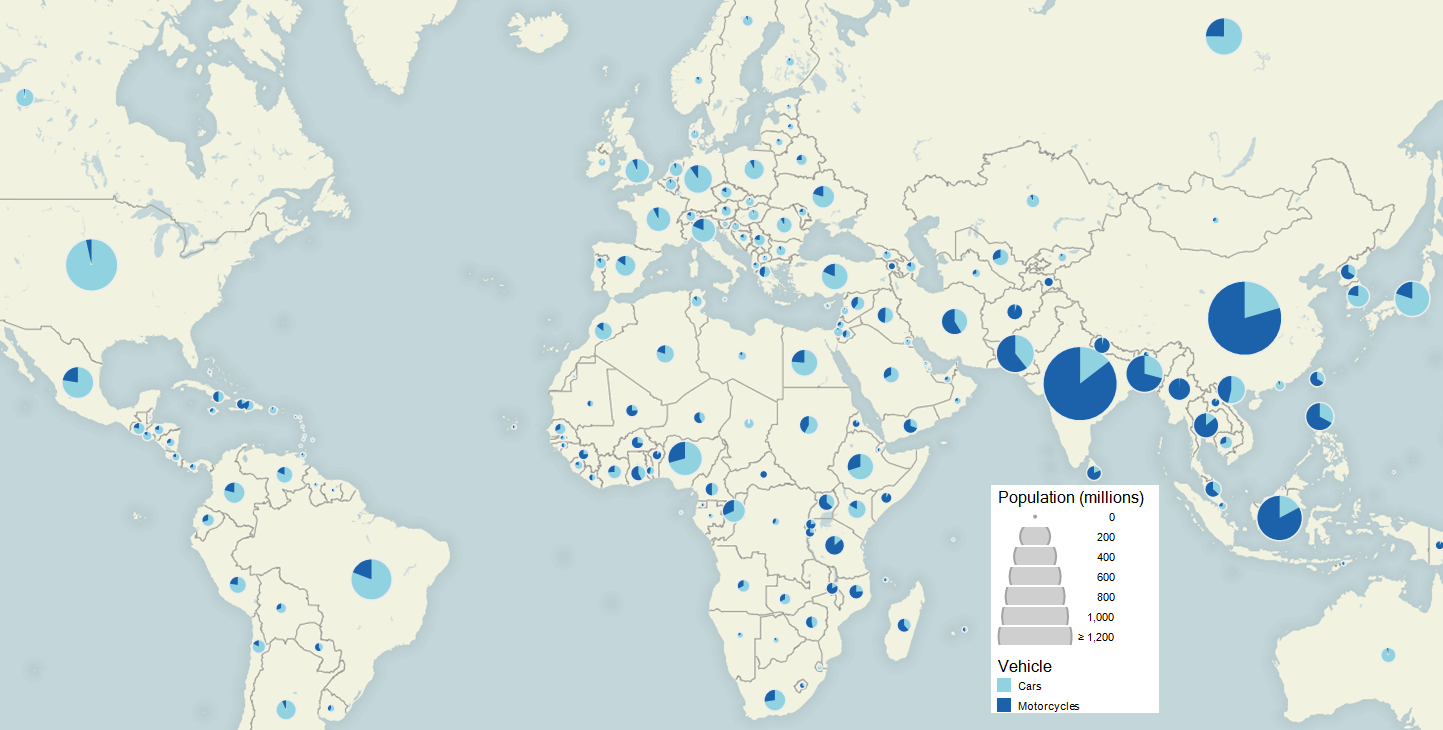




Model Response:
This image is a global map that displays the distribution of vehicle types (cars and motorcycles) across various countries, represented by pie charts. The size of each pie chart corresponds to the population of the country, with larger circles indicating higher populations. The legend in the bottom right corner explains the color coding: light blue for cars and dark blue for motorcycles.

### Key Patterns and Trends:
1. **Population Density**: Larger pie charts are concentrated in highly populated countries such as China, India, and the United States.
2. **Vehicle Preference**:
   - **Cars**: Many countries, especially in Europe, North America, and parts of South America, show a higher proportion of cars.
   - **Motorcycles**: Countries in Southeast Asia, such as Indonesia, Vietnam, and Thailand, have a significant proportion of motorcycles.
3. **Urbanization and Economy**: More urbanized and economically developed regions tend to have a higher proportion of cars.

#

In [3]:
prompt = """Analyze this data visualization and provide insights:

1. What information is being displayed?
2. What are the key patterns and trends?
3. Which regions show interesting outliers?
4. What factors might explain the geographic variations?
"""

image_path = "images/Map_Motorcycles_vs_cars_by_population_millions_2002.png"
response = get_mistral_response(prompt, image_path)

print("\nModel Response:")
print(response)

### Use Case 2: Document Structure Extraction

Input Image:



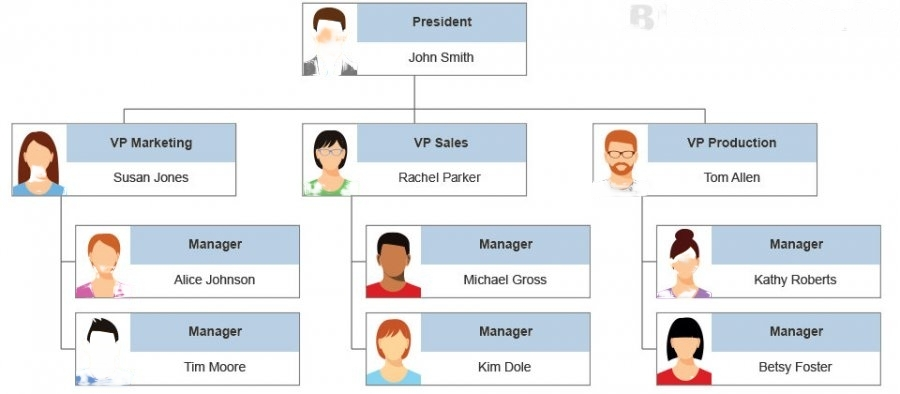




Model Response:
Here is the organizational hierarchy extracted from the org chart in structured JSON format:

```json
[
  {
    "role": "President",
    "name": "John Smith",
    "reporting_manager": null
  },
  {
    "role": "VP Marketing",
    "name": "Susan Jones",
    "reporting_manager": "John Smith"
  },
  {
    "role": "VP Sales",
    "name": "Rachel Parker",
    "reporting_manager": "John Smith"
  },
  {
    "role": "VP Production",
    "name": "Tom Allen",
    "reporting_manager": "John Smith"
  },
  {
    "role": "Manager",
    "name": "Alice Johnson",
    "reporting_manager": "Susan Jones"
  },
  {
    "role": "Manager",
    "name": "Tim Moore",
    "reporting_manager": "Susan Jones"
  },
  {
    "role": "Manager",
    "name": "Michael Gross",
    "reporting_manager": "Rachel Parker"
  },
  {
    "role": "Manager",
    "name": "Kim Dole",
    "reporting_manager": "Rachel Parker"
  },
  {
    "role": "Manager",
    "name": "Kathy Roberts",
    "reporting_manager": "Tom All

In [4]:
prompt = """Extract the organizational hierarchy from this org chart. 
Provide the response in structured JSON format with:
- role
- name  
- reporting_manager
"""

image_path = "images/org_hierarchy.jpeg"
response = get_mistral_response(prompt, image_path, temperature=0.3)

print("\nModel Response:")
print(response)

## Part 2: Mistral Small 3 - High-Performance Text Model

**Mistral Small 3** delivers exceptional performance with:
- **24B parameters** with 81% MMLU accuracy
- **150 tokens/second** processing speed
- **Apache 2.0 license** for commercial use
- **32K context window** with multilingual support

### Deploy on SageMaker Marketplace

In [6]:
# Skip this step during workshop 
# Configuration
REGION = "us-west-2" #change region if needed
MODEL_SOURCE_ID = 'huggingface-llm-mistral-small-24B-Instruct-2501'
MODEL_SOURCE_ARN = f'arn:aws:sagemaker:{REGION}:aws:hub-content/SageMakerPublicHub/Model/huggingface-llm-mistral-small-24B-Instruct-2501/2.0.3'
INSTANCE_TYPE = 'ml.g6.12xlarge'
ENDPOINT_NAME = 'mistral-small-serverfull' 

# Get session info
def get_current_session_info():
    sagemaker_role_arn = sagemaker.get_execution_role()
    session = sagemaker.Session()
    account_id = session.account_id()
    region = session._region_name
    return account_id, region, sagemaker_role_arn

aws_account_id, aws_region, sagemaker_role_arn = get_current_session_info()

In [ ]:
# Skip this step during workshop 
# Create bedrock marketplace endpoint
bedrock_client = boto3.client('bedrock')

def create_endpoint(model_source_arn: str, endpoint_name: str, instance_type: str, instance_count: int = 1):
    response = bedrock_client.create_marketplace_model_endpoint(
        modelSourceIdentifier=model_source_arn,
        endpointConfig={
            'sageMaker': {
                'initialInstanceCount': instance_count,
                'instanceType': instance_type,
                'executionRole': sagemaker_role_arn,
            }
        },
        acceptEula=True,
        endpointName=endpoint_name
    )
    return response

create_response = create_endpoint(
    model_source_arn=MODEL_SOURCE_ARN,
    endpoint_name=ENDPOINT_NAME,
    instance_type=INSTANCE_TYPE
)

endpoint_arn = create_response['marketplaceModelEndpoint']['endpointArn']
print(f"Endpoint creation initiated. ARN: {endpoint_arn}")

In [ ]:
# Wait for endpoint to be ready
while True:
    endpoint_response = bedrock_client.get_marketplace_model_endpoint(endpointArn=endpoint_arn)
    status = endpoint_response['marketplaceModelEndpoint']['endpointStatus']
    print(f'Endpoint status: {status}')
    if status != 'Creating':
        break
    time.sleep(30)

print("✅ Endpoint is ready!")

### Helper Functions for Bedrock Runtime

In [5]:
bedrock_runtime = boto3.client("bedrock-runtime")

def bedrock_converse(system_prompt: str, messages: list, endpoint_arn: str, display_usage=False):
    """Invoke model using Converse API"""
    system = [{"text": system_prompt}]
    
    response = bedrock_runtime.converse(
        modelId=endpoint_arn,
        messages=messages,
        system=system,
        additionalModelRequestFields={"max_tokens": 2000, "temperature": 0.3}
    )

    output_content = ''.join(
        content['text'] for content in response['output']['message']['content']
    )

    if display_usage:
        token_usage = response['usage']
        print(f"\tLatency: {response['metrics']['latencyMs']}ms")
    
    return output_content

def bedrock_converse_stream(system_prompt: str, messages: list, endpoint_arn: str):
    """Invoke model with streaming"""
    system = [{"text": system_prompt}]
    
    response = bedrock_runtime.converse_stream(
        modelId=endpoint_arn,
        messages=messages,
        system=system,
        additionalModelRequestFields={"max_tokens": 2000, "temperature": 0.3}
    )
    
    stream = response.get('stream')
    output_content = ''
    
    if stream:
        for event in stream:
            if 'messageStart' in event:
                print(f"\nRole: {event['messageStart']['role']}")
            
            if 'contentBlockDelta' in event:
                text_chunk = event['contentBlockDelta']['delta']['text']
                print(text_chunk, end="")
                output_content += text_chunk
            
            if 'messageStop' in event:
                print(f"\nStop reason: {event['messageStop']['stopReason']}")
            
            if 'metadata' in event:
                metadata = event['metadata']
                if 'metrics' in metadata:
                    print(f"Latency: {metadata['metrics']['latencyMs']}ms")
    
    return output_content

In [6]:
# Retrieve endpoint arn from response text

# endpoint_arn = create_response['marketplaceModelEndpoint']['endpointArn']
endpoint_arn = "<ENDPOINT_ARN>" # replace with your endpoint ARN  

## Usage Cases


### Text Classification


In [8]:
system_prompt = '''
You are an AI assistant tasked with classifying data based on its sensitivity level. The sensitivity levels and their definitions are:

Sensitive: Data that is to have the most limited access and requires a high degree of integrity. This is typically data that will do the most damage to the organization should it be disclosed.
Confidential: Data that might be less restrictive within the company but might cause damage if disclosed.
Private: Private data is usually compartmental data that might not do the company damage but must be kept private for other reasons. Human resources data is one example of data that can be classified as private.
Proprietary: Proprietary data is data that is disclosed outside the company on a limited basis or contains information that could reduce the company's competitive advantage, such as the technical specifications of a new product.
Public: Public data is the least sensitive data used by the company and would cause the least harm if disclosed. This could be anything from data used for marketing to the number of employees in the company.

For each user inquery provided, classify it into one of the above sensitivity levels. Do not include the word "Category". Do not provide explanations or notes.
'''

In [9]:
messages = [
    {
        "role": "user",
        "content": [{"text": "I'm an HR recruiter. What data classifiction category are resumes gathered based on referral by employees?"}]
    }
]

bedrock_converse_stream(system_prompt, messages, endpoint_arn)


Role: assistant
Private
Stop reason: end_turn
Latency: 589ms


'Private'

In [10]:
messages = [
    {
        "role": "user",
        "content": [{"text": "I require the financial statements for the past three fiscal years."}]
    }
]
bedrock_converse_stream(system_prompt, messages, endpoint_arn)


Role: assistant
Sensitive
Stop reason: end_turn
Latency: 297ms


'Sensitive'

### Fraudulent Call Detection

Mistral Small 3 analyzes transcripts of suspicious phone calls, identifying common deception tactics and social engineering patterns used by scammers. The system automatically flags potential fraud indicators - like urgency manipulation, impersonation of authority figures, and unusual payment requests - helping financial institutions and call centers rapidly detect and respond to emerging scam attempts while protecting vulnerable customers.

In [11]:
system_prompt = '''
Please analyze this call/message for potential scam activity. Rate each indicator as 1 (present) or 0 (absent):

[ID] Missing/incomplete identification (name/company/ID): [0/1]
[OFFER] Suspicious offers or too-good-to-be-true promises: [0/1]
[VAGUE] Non-specific references instead of account details: [0/1]
[REDIRECT] Unsolicited direction to unofficial channels: [0/1]
[URGENT] Pressure tactics or urgent deadlines: [0/1]
Total flags: [X/5]
Brief analysis: [1-2 sentence conclusion]'''

user_prompt = ''' 
Hi there, this is Jessie calling in regards to your Honda warranty. The warranty is up for renewal. 
I’d like to congratulate you on your $2,000 instant rebate and free maintenance and oil change package for being a loyal customer. 
Call me back at 934-153-XXXX to redeem now. Once again that number was 934-153-XXXX. Thank you so much. Have a great day. 
'''

In [12]:
messages = [
    {"role": "user", "content": [{"text": user_prompt}]}
]
bedrock_converse_stream(system_prompt, messages, endpoint_arn)


Role: assistant
[ID] Missing/incomplete identification (name/company/ID): [1]
[OFFER] Suspicious offers or too-good-to-be-true promises: [1]
[VAGUE] Non-specific references instead of account details: [1]
[REDIRECT] Unsolicited direction to unofficial channels: [1]
[URGENT] Pressure tactics or urgent deadlines: [1]
Total flags: [5/5]

Brief analysis: This message exhibits all the classic signs of a scam, including a lack of proper identification, an enticing offer that seems too good to be true, vague references, a request to call an unfamiliar number, and a sense of urgency to act immediately.
Stop reason: end_turn
Latency: 7413ms


'[ID] Missing/incomplete identification (name/company/ID): [1]\n[OFFER] Suspicious offers or too-good-to-be-true promises: [1]\n[VAGUE] Non-specific references instead of account details: [1]\n[REDIRECT] Unsolicited direction to unofficial channels: [1]\n[URGENT] Pressure tactics or urgent deadlines: [1]\nTotal flags: [5/5]\n\nBrief analysis: This message exhibits all the classic signs of a scam, including a lack of proper identification, an enticing offer that seems too good to be true, vague references, a request to call an unfamiliar number, and a sense of urgency to act immediately.'

### 3. Mistral OCR model

In [14]:
import base64
import os
from typing import Optional,Dict, Any
from IPython.display import Markdown, display

## Helper functions for image processing, model invocation and post response processing 

def encode_local_file_base64(file_path: str, file_type: Optional[str] = None) -> str:
    
    if file_type is None:
        ext = os.path.splitext(file_path)[1].lower()
        if ext == ".pdf":
            file_type = "pdf"
        elif ext in (".jpg", ".jpeg", ".png", ".gif", ".bmp", ".webp"):
            file_type = "image"
        else:
            raise ValueError(f"Unsupported file type from extension: {ext}")

    try:
        with open(file_path, "rb") as file:
            encoded_data = base64.b64encode(file.read()).decode("utf-8")
            return encoded_data
    except Exception as e:
        print(f"Failed to encode {file_type} at {file_path}: {e}")
        raise

def run_inference(client, endpoint_name: str, payload: dict[str,Any]) -> Dict[str, Any]:
    """
    Invoke the SageMaker endpoint for OCR inference.
    
    Args:
        client: SageMaker runtime client
        endpoint_name: Name of the deployed endpoint
        payload: JSON payload containing the image data
        
    Returns:
        Dictionary containing parsed OCR results
    """
    try:
        inference_out = client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/json",
            Body=json.dumps(payload)
        )
        inference_resp_str = inference_out["Body"].read().decode("utf-8")
        return json.loads(inference_resp_str)
    except Exception as e:
        print(f"Inference error: {e}")
        raise


def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    """
    Replace image placeholders in markdown with base64-encoded images.
    """
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(
            f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})"
        )
    return markdown_str

def get_combined_markdown(ocr_response: dict) -> str:
    """
    Combine OCR text and images into a single markdown document.
    """
    markdowns = []
    for page in ocr_response["pages"]:
        image_data = {img["id"]: img["image_base64"] for img in page.get("images", [])}
        markdown_with_images = replace_images_in_markdown(page["markdown"], image_data)
        markdowns.append(markdown_with_images)
    return "\n\n".join(markdowns)

In [15]:
MISTRAL_OCR_ENDPOINT_NAME = "mistral-ocr-endpoint"
image_b64 = encode_local_file_base64(file_path="images/french.png")

# Prepare the payload for Mistral OCR model
payload = {
    "model": "mistral-ocr-2505",
    "document": {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{image_b64}"
    }
}

# Create a client and invoke the endpoint
sagemaker_client = boto3.client("sagemaker-runtime")
result_parsed = run_inference(client=sagemaker_client, endpoint_name=MISTRAL_OCR_ENDPOINT_NAME, payload=payload)

# Display final markdown content with embedded images
display(Markdown(get_combined_markdown(result_parsed)))

# Souvenez-Vous! 

## A TOUS LES FRANCAIS

La France a perdu une bataille!
Mais la France n'a pas perdu la guerre!
Des gouvernants de rencontre ont pu capituler, cédant à la panique, oubliant l'honneur, livrant le pays à la servitude. Cependant, rien n'est perdu!

Rien n'est perdu, parce que cette guerre est une guerre mondiale. Dans l'univers libre, des forces immenses n'ont pas encore donné. Un jour, ces forces écraseront l'ennemi. Il faut que la France, ce jour-là, soit présente à la victoire. Alors, elle retrouvera sa liberté et sa grandeur. Tel est mon but, mon seul but!

Voilà pourquoi je convie tous les Français, où qu'ils se trouvent, à s'unir à moi dans l'action, dans le sacrifice et dans l'espérance.

Notre patrie est en péril de mort.
Luttons tous pour la sauver!
![img-0.jpeg](None)

## 4. Building a document understanding pipeline with Mistral OCR model and Mistral Small 3.0 

### Multimodal Content Generation for Technical Documentation




In [16]:
def document_understanding_pipeline(
    image_path: str,
    user_prompt: str,
    ocr_endpoint: str,
    llm_endpoint: str
) -> str:
    """
    Full pipeline for document understanding from image input.

    Args:
        image_path: Local path to the document image
        user_prompt: What insights the user wants to extract
        ocr_endpoint: SageMaker endpoint for OCR model
        llm_endpoint: Bedrock endpoint for document understanding LLM

    Returns:
        Model-generated response with document insights
    """

    # Step 1: Encode local file using helper
    encoded_image = encode_local_file_base64(image_path)

    payload = {
        "model": "mistral-ocr-2505",
        "document": {
            "type": "image_url",
            "image_url": f"data:image/jpeg;base64,{image_b64}"
        }
    }

    # Step 2: Run OCR model
    print("Running OCR model...")
    ocr_result = run_inference(client=sagemaker_client, endpoint_name=ocr_endpoint, payload=payload)

    # Step 3: Convert OCR output to Markdown
    print("Formatting OCR output...")
    markdown_doc = get_combined_markdown(ocr_result)

    print("----- OCR Text  -----")
    display(Markdown(markdown_doc))

    # Step 4: Prepare LLM messages
    system_prompt = (
        "You are a document understanding assistant. The user will provide structured OCR content "
        "from a scanned document. Use that information to generate clear, factual insights that "
        "answer the user's request."
    )

    messages = [
        {
            "role": "user",
            "content": [{"text": f"{user_prompt}\n\n--- Document Content ---\n{markdown_doc}"}]
        }
    ]

    # Step 5: Call Bedrock LLM with streaming
    print("Running LLM for document insights...")
    insights = bedrock_converse_stream(system_prompt, messages, llm_endpoint)

    return insights

In [17]:
image_path = "images/french.png"
user_prompt = "can you summarise this document"
ocr_endpoint = MISTRAL_OCR_ENDPOINT_NAME
llm_endpoint = endpoint_arn  # Mistral small 3.0 endpoint ARN (Bedrock Marketplace or SageMaker Jumpstart)
document_understanding_pipeline(image_path, user_prompt, ocr_endpoint, llm_endpoint)

Running OCR model...
Formatting OCR output...
----- OCR Text  -----


# Souvenez-Vous! 

## A TOUS LES FRANCAIS

La France a perdu une bataille!
Mais la France n'a pas perdu la guerre!
Des gouvernants de rencontre ont pu capituler, cédant à la panique, oubliant l'honneur, livrant le pays à la servitude. Cependant, rien n'est perdu!

Rien n'est perdu, parce que cette guerre est une guerre mondiale. Dans l'univers libre, des forces immenses n'ont pas encore donné. Un jour, ces forces écraseront l'ennemi. Il faut que la France, ce jour-là, soit présente à la victoire. Alors, elle retrouvera sa liberté et sa grandeur. Tel est mon but, mon seul but!

Voilà pourquoi je convie tous les Français, où qu'ils se trouvent, à s'unir à moi dans l'action, dans le sacrifice et dans l'espérance.

Notre patrie est en péril de mort.
Luttons tous pour la sauver!
![img-0.jpeg](None)

Running LLM for document insights...

Role: assistant
### Summary

The document, titled "Souvenez-Vous!" (Remember!), is a call to action addressed to all French people. Here are the key points:

1. **Current Situation**:
   - France has lost a battle but not the war.
   - The government has capitulated, succumbing to panic and forgetting honor, leading to the country's servitude.

2. **Hope for the Future**:
   - The war is global, and immense forces in the free world have not yet been fully engaged.
   - These forces will eventually crush the enemy.
   - France must be ready to participate in the ultimate victory to regain its freedom and grandeur.

3. **Call to Action**:
   - The author invites all French people, regardless of their location, to unite in action, sacrifice, and hope.
   - The homeland is in grave danger, and everyone must fight to save it.

The document is a rallying cry for unity and resistance, emphasizing that France's ultimate victory and restoration are within r

'### Summary\n\nThe document, titled "Souvenez-Vous!" (Remember!), is a call to action addressed to all French people. Here are the key points:\n\n1. **Current Situation**:\n   - France has lost a battle but not the war.\n   - The government has capitulated, succumbing to panic and forgetting honor, leading to the country\'s servitude.\n\n2. **Hope for the Future**:\n   - The war is global, and immense forces in the free world have not yet been fully engaged.\n   - These forces will eventually crush the enemy.\n   - France must be ready to participate in the ultimate victory to regain its freedom and grandeur.\n\n3. **Call to Action**:\n   - The author invites all French people, regardless of their location, to unite in action, sacrifice, and hope.\n   - The homeland is in grave danger, and everyone must fight to save it.\n\nThe document is a rallying cry for unity and resistance, emphasizing that France\'s ultimate victory and restoration are within reach if the people stand together.

### Clean up

We will clean up the resources at the end of the entire workshop. The model endpoints will be used in later workshops.

In [ ]:
# bedrock_client.delete_marketplace_model_endpoint(endpointArn=endpoint_arn)

## 🎉 Workshop Complete!

You've successfully explored Mistral AI models on AWS!

### ✅ What You've Accomplished:
1. **Deployed Pixtral Large** for multimodal vision tasks on Amazon Bedrock
2. **Used Mistral Small 3** for high-performance text processing on SageMaker
3. **Deployed Mistral OCR model** for document extration
4. **Created document understanding** pipelines combining OCR and LLM capabilities

### 🚀 Next Steps:
- **Build MCP applications** with Workshop 2 for tool-augmented AI assistants
- **Explore fine-tuning** with Workshop 3 to customize models for your domain